In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import seaborn as sns
%matplotlib inline

# 0. Load data into pandas dataframe

In [2]:
sf_scooter = pd.read_csv('trip.csv')

In [3]:
sf_scooter.head()

,id,duration,start_date,start_station_name,start_station_id,end_date,end_station_name,end_station_id,bike_id,subscription_type,zip_code
0,4576,63,8/29/2013 14:13,South Van Ness at Market,66,8/29/2013 14:14,South Van Ness at Market,66,520,Subscriber,94127
1,4607,70,8/29/2013 14:42,San Jose City Hall,10,8/29/2013 14:43,San Jose City Hall,10,661,Subscriber,95138
2,4130,71,8/29/2013 10:16,Mountain View City Hall,27,8/29/2013 10:17,Mountain View City Hall,27,48,Subscriber,97214
3,4251,77,8/29/2013 11:29,San Jose City Hall,10,8/29/2013 11:30,San Jose City Hall,10,26,Subscriber,95060
4,4299,83,8/29/2013 12:02,South Van Ness at Market,66,8/29/2013 12:04,Market at 10th,67,319,Subscriber,94103


# 1. The distribution of usage duration of scooter
## 1.1 Group the duration into hours and minutes

In [4]:
sf_scooter['Duration_minutes'] = (sf_scooter['duration']/60).astype('int64')
sf_scooter['Duration_hours'] = (sf_scooter['duration']/3600).astype('int64')

## 1.2 plot the distribution in terms of hours
We can see most of the trips will ends within one hour, while there are some outliers stand at 100 hours or 200 hours. That may be due to the users forgot to return the scooters or some other issues. However, we will focus on the samples located around 1 hour to see what does the distribution look like there.

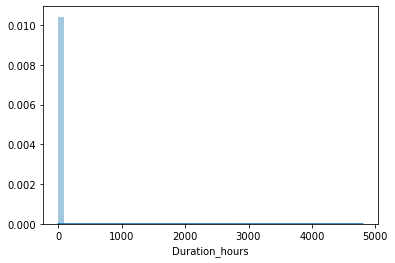

In [5]:
sns.distplot(sf_scooter['Duration_hours'])

This distribution further confirms our understanding that most of the trips are within 1 hour.

# 1.3 Plot the distribution in terms of minutes

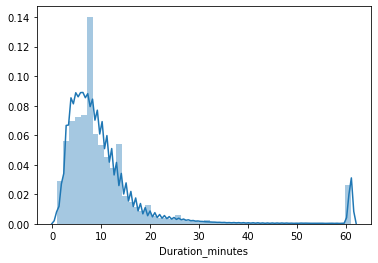

In [6]:
sns.distplot(sf_scooter['Duration_minutes'].where(sf_scooter['Duration_minutes'] <= 60, 61))

From the distribution plot, we can see most of the trips end within 20 minutes. 

In [7]:
sf_scooter['Duration_minutes'].describe()

count    669959.000000
mean         17.973842
std         370.924710
min           1.000000
25%           5.000000
50%           8.000000
75%          12.000000
max      287840.000000
Name: Duration_minutes, dtype: float64

The median of the duration is at 8 minutes. 75% of the trips will be finished within 12 minutes. The mean value deviates from the median, as there is a long tail in the distribution.

In [8]:
sf_scooter['Duration_minutes'].quantile(0.95)

31.0

95% percent of the trips can be finished within 31 minutes.

## 2. The number of transportations across time

## 2.1 The travelling frequency on different hours.

In [9]:
sf_scooter['start_date'] = sf_scooter['start_date'].apply(lambda x: pd.to_datetime(x))
sf_scooter['end_date'] = sf_scooter['end_date'].apply(lambda x: pd.to_datetime(x))
sf_scooter['start_hour'] = sf_scooter['start_date'].dt.hour.astype('int64')
sf_scooter['end_date'] = sf_scooter['end_date'].dt.hour.astype('int64')

From the graph, we can see that the peak hour in terms of start time would be 7, 8, 9 am and 16, 17, 18 pm. That may be caused by the commuting transportation when people go to work and go off work everyday. 

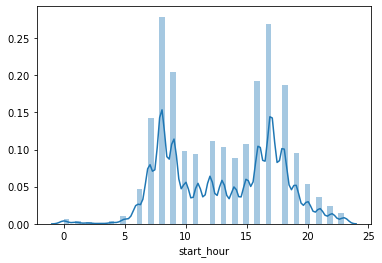

In [10]:
sns.distplot(sf_scooter['start_hour'])

## 2.2 The travelling frequency on different days.

In [11]:
sf_scooter["week_day"] = sf_scooter["start_date"].dt.strftime("%d").astype("int64") % 7
sf_scooter["date"] = sf_scooter["start_date"].dt.strftime("%Y-%m-%d")
sf_scooter.loc[sf_scooter["week_day"] == 0, "week_day"] = 7

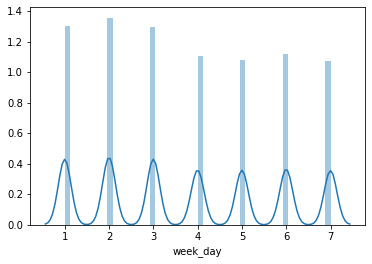

In [12]:
sns.distplot(sf_scooter["week_day"])

It is interesting that the trips on weekend is instead higher than that on weekdays. Next, we dig deeper to see which station accounts for the most number of trips. 

## 2.3 The hot routes in morning rush hours

### 2.3.1 Start Stations

In [13]:
morning = sf_scooter[sf_scooter['start_hour'].isin((7,8,9))]

In [14]:
morning.head()

,id,duration,start_date,start_station_name,start_station_id,end_date,end_station_name,end_station_id,bike_id,subscription_type,zip_code,Duration_minutes,Duration_hours,start_hour,week_day,date
32,4069,174,2013-08-29 09:08:00,2nd at South Park,64,9,2nd at South Park,64,288,Subscriber,94114,2,0,9,1,2013-08-29
34,4086,178,2013-08-29 09:42:00,Commercial at Montgomery,45,9,Commercial at Montgomery,45,379,Subscriber,94402,2,0,9,1,2013-08-29
55,4081,218,2013-08-29 09:38:00,Mountain View City Hall,27,9,Mountain View City Hall,27,150,Subscriber,97214,3,0,9,1,2013-08-29
91,4084,287,2013-08-29 09:41:00,Mountain View City Hall,27,9,Mountain View City Hall,27,138,Customer,97214,4,0,9,1,2013-08-29
398,4080,764,2013-08-29 09:36:00,South Van Ness at Market,66,9,San Francisco Caltrain 2 (330 Townsend),69,315,Subscriber,94117,12,0,9,1,2013-08-29


Group by the start station and count the distinct number of trip ids for each start station.
From the table below, we can see 14.7% of passengers start form terminal, which is 2 times higher than the terminal ranked at the second place. Hence there is a significant gap between terminal 70 and the other terminals. 

In [15]:
df_start_station = morning.groupby('start_station_name').agg({'start_station_id': np.mean, 'id': pd.Series.nunique}).sort_values(['id'], ascending=False)
df_start_station['percentage'] = df_start_station['id']/sum(df_start_station['id'])
df_start_station.head()

,start_station_id,id,percentage
start_station_name,,,
San Francisco Caltrain (Townsend at 4th),70,26067,0.135272
San Francisco Caltrain 2 (330 Townsend),69,16678,0.086549
Harry Bridges Plaza (Ferry Building),50,12887,0.066876
Temporary Transbay Terminal (Howard at Beale),55,12565,0.065205
Steuart at Market,74,9321,0.048371


In [16]:
df_start_station[:8]["percentage"].sum()

0.5045407368967306

The top 8 stations account for 50% of the trips

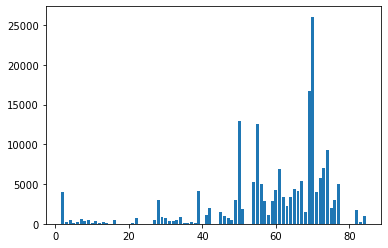

In [17]:
plt.bar(df_start_station['start_station_id'], df_start_station['id'], align='center')#, alpha=0.5)
plt.show()

### 2.3.1 End Stations

For the end stations, terminal 70 is still the top one place, while the whole sample is more evenly distributed. Combined with the previous discussion, these two tables imply that there is a large amount of people start from terminal 70 and head to different places in every morning. 

In [18]:
df_end_station = morning.groupby('end_station_name').agg({'end_station_id': np.mean, 'id': pd.Series.nunique}).sort_values(['id'], ascending=False)
df_end_station['percentage'] = df_end_station['id']/sum(df_end_station['id'])
df_end_station

,end_station_id,id,percentage
end_station_name,,,
San Francisco Caltrain (Townsend at 4th),70,14220,0.073793
2nd at Townsend,61,10986,0.057011
Townsend at 7th,65,10938,0.056762
Market at Sansome,77,9265,0.048080
Embarcadero at Sansome,60,7813,0.040545
...,...,...,...
SJSU - San Salvador at 9th,16,60,0.000311
Rengstorff Avenue / California Street,33,55,0.000285
Mezes Park,83,36,0.000187


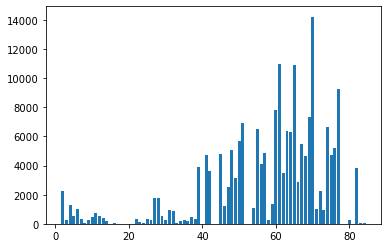

In [19]:
plt.bar(df_end_station['end_station_id'], df_end_station['id'], align='center')
plt.show()

The Pareto principle (80/20 rule) still exists, but not so obvious. Further explaination and visualization goes to the tableau file. 

## 2.4 The heatmap of demand and supply of the scooters in different stations.

such that people can know which place needs more scooters and which does not.

In [20]:
num_days = len(morning["date"].unique())

In [24]:
start_station = morning.groupby(['start_station_name', 'start_station_id']).agg(start_trips=('id', pd.Series.nunique)) \
.reset_index() \
.rename(columns={"start_station_name": "station", "start_station_id": "station_id"})

# calculate the average start trips
start_station = start_station.assign(ave_start_trips = start_station["start_trips"] / num_days)

end_station = morning.groupby(['end_station_name', 'end_station_id']).agg(end_trips=('id', pd.Series.nunique)) \
.reset_index() \
.rename(columns={"end_station_name": "station", "end_station_id": "station_id"})

# calcuate the average end trips
end_station = end_station.assign(ave_end_trips = end_station["end_trips"] / num_days)

In [28]:
start_end = start_station.merge(end_station, on=("station", "station_id"))[["station", "ave_start_trips", "ave_end_trips"]].set_index("station")

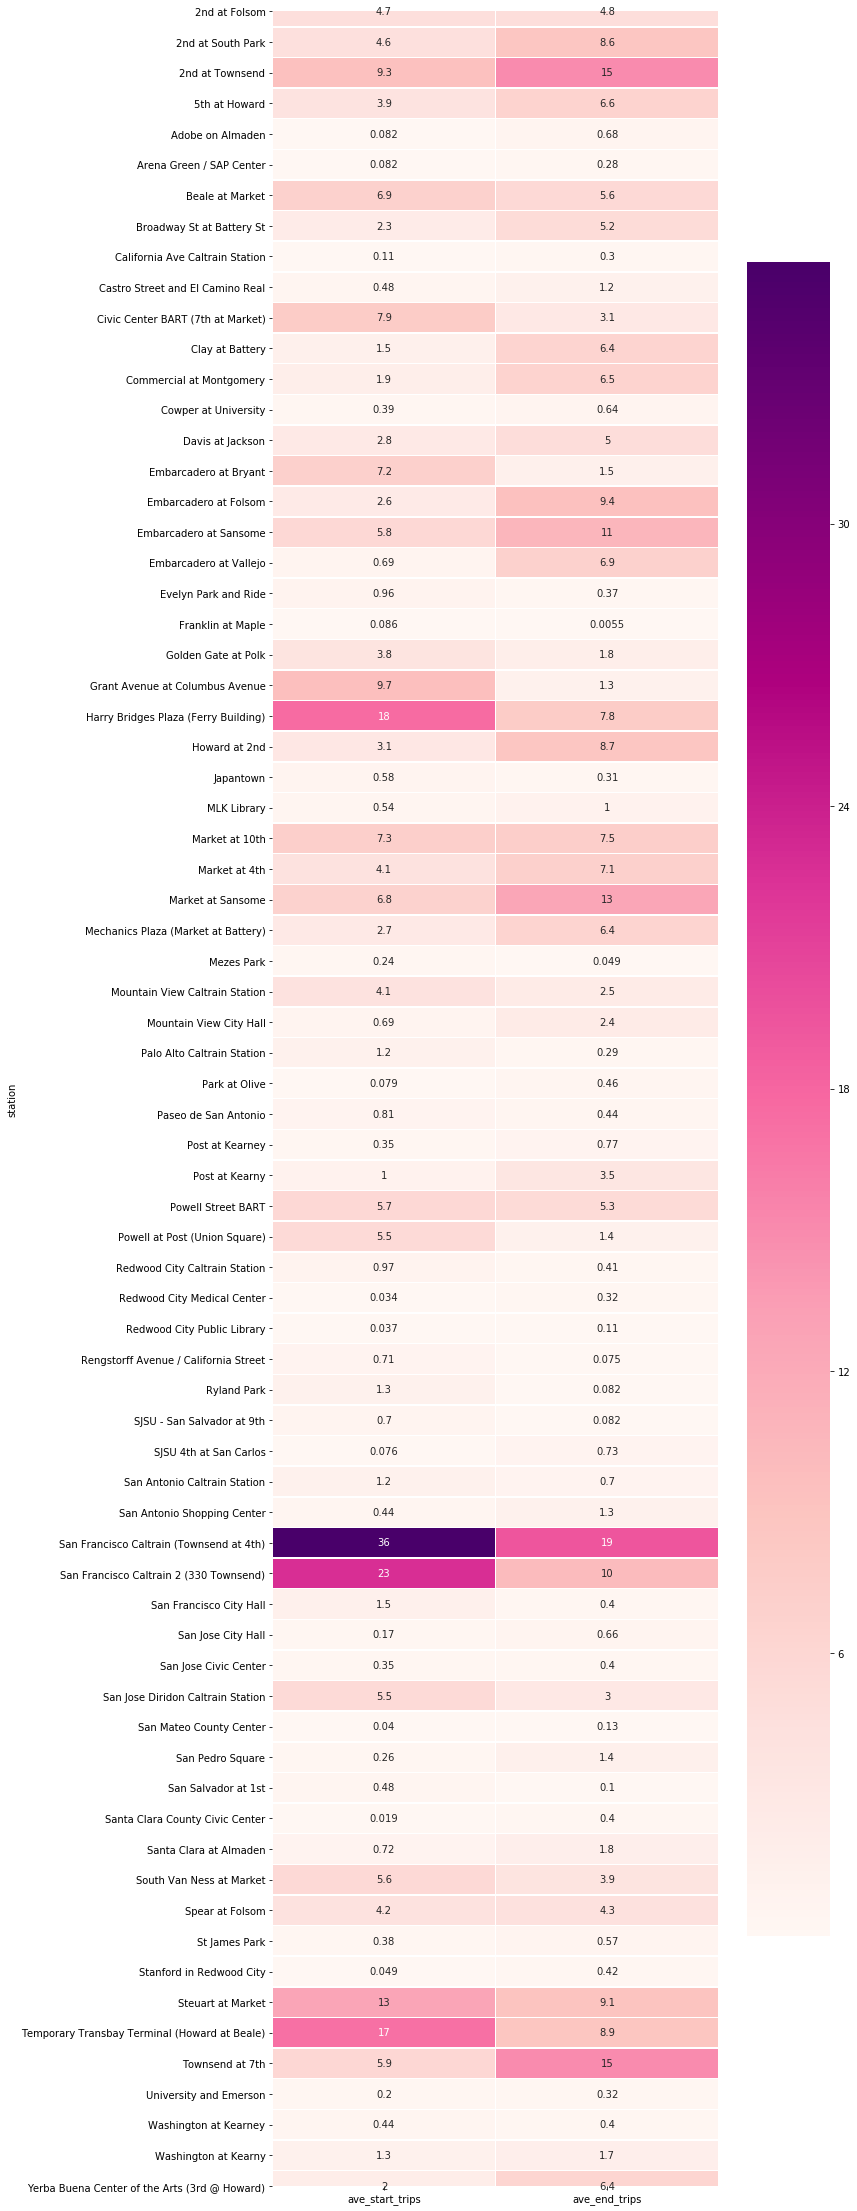

In [29]:
fig, ax = plt.subplots(figsize=(10,40))
sns.heatmap(start_end, ax=ax, annot=True, fmt=".2g", linewidths=.5, cmap="RdPu")

Filter the stations that need more scooters. Select by 

In [30]:
start_end[(start_end["ave_start_trips"] > start_end["ave_end_trips"] * 1.2) 
          & (start_end["ave_start_trips"] > start_end["ave_end_trips"] + 1)]

,ave_start_trips,ave_end_trips
station,,
Beale at Market,6.911323,5.596180
Civic Center BART (7th at Market),7.879945,3.058663
Embarcadero at Bryant,7.201910,1.499318
Golden Gate at Polk,3.833561,1.818554
Grant Avenue at Columbus Avenue,9.658936,1.253752
Harry Bridges Plaza (Ferry Building),17.581173,7.791269
Mountain View Caltrain Station,4.061392,2.451569
Powell at Post (Union Square),5.525239,1.379263
Ryland Park,1.278308,0.081855


In [89]:
import geopandas as gpd
import geopy 
from shapely.geometry import Point, Polygon
from pyproj import Proj
import fiona

# https://dmuhs.blog/2018/09/14/parsing-kmz-track-data-in-python/
from zipfile import ZipFile

# Enable fiona driver
gpd.io.file.fiona.drvsupport.supported_drivers['KML'] = 'rw'

In [32]:
stations = pd.read_csv("station.csv")

In [101]:
start_end_geo = start_end.reset_index().merge(stations, left_on="station", right_on="name")
start_end_geo["diff"] = start_end_geo["ave_start_trips"] - start_end_geo["ave_end_trips"]
to_utm = Proj("+proj=utm +zone=10S, +south +ellps=WGS84 +datum=WGS84 +units=m +no_defs")

In [108]:
geo_utm = gpd.GeoDataFrame(start_end_geo)
geo_latlong = gpd.GeoDataFrame(start_end_geo.copy())

geo_utm["geometry"] = pd.Series([Point(to_utm(x,y)) for x, y in zip(start_end_geo["long"], start_end_geo["lat"])])
geo_latlong["geometry"] = pd.Series([Point(x,y) for x, y in zip(start_end_geo["long"], start_end_geo["lat"])])

In [36]:
# https://earthworks.stanford.edu/catalog/stanford-df986nv4623
# import geopandas as gpd
# import geopy 
# from geopy.geocoders import Nominatim
# from geopy.extra.rate_limiter import RateLimiter

# locator = Nominatim(user_agent="myGeocoder")
# geocoder = RateLimiter(locator.geocode, min_delay_seconds=2)

# full_address = pd.DataFrame(
#     np.unique(np.concatenate((sf_scooter["Start Station"].unique(), sf_scooter["End Station"].unique()), 0)), columns=["Stations"]
# )

# full_address["Locations"] = full_address["Stations"].apply(geocoder)

# full_address.loc[8, ['latitude', 'longitude', 'altitude']] = (None, None, None)
# full_address.loc[20, ['latitude', 'longitude', 'altitude']] = tuple(geocoder("321E E Evelyn Ave, Mountain View, CA 94041, United States").point)
# full_address.loc[21, ['latitude', 'longitude', 'altitude']] = (None, None, None)
# full_address.loc[35, ['latitude', 'longitude', 'altitude']] = tuple(geocoder("California Avenue Train Station").point)
# full_address.loc[36, ['latitude', 'longitude', 'altitude']] = (None, None, None)
# full_address.loc[38, ['latitude', 'longitude', 'altitude']] = tuple(geocoder("Kearny St & Post St, San Francisco, CA 94108, USA").point)
# full_address.loc[41, ['latitude', 'longitude', 'altitude']] = tuple(geocoder("700 4th St, San Francisco, CA 94107, United States").point)
# full_address.loc[44, ['latitude', 'longitude', 'altitude']] = tuple(geocoder("Rengstorff Ave & California St, Mountain View, CA 94040, USA").point)
# full_address.loc[45, ['latitude', 'longitude', 'altitude']] = tuple(geocoder("Ryland Park, First Street & Fox Avenue, San Jose, CA, USA").point)
# full_address.loc[46, ['latitude', 'longitude', 'altitude']] = tuple(geocoder("San Salvador St at 9th St, San Jose, CA 95112, United States").point)
# full_address.loc[48, ['latitude', 'longitude', 'altitude']] = tuple(geocoder("195 San Antonio Cir, Mountain View, CA 94040, USA").point)
# full_address.loc[51, ['latitude', 'longitude', 'altitude']] = tuple(geocoder("330 Townsend St San Francisco, CA 94107 United States").point)
# full_address.loc[63, ['latitude', 'longitude', 'altitude']] = tuple(geocoder("Central San Jose, San Jose, CA 95112, USA").point)
# full_address.loc[65, ['latitude', 'longitude', 'altitude']] = tuple(geocoder("San Francisco, CA 94105, United States").point)

# full_address["Points"] = full_address["Locations"].apply(lambda x: (x.point) if x else (None, None, None)) 
# full_address[['latitude', 'longitude', 'altitude']] = pd.DataFrame(full_address['Points'].tolist(), index=full_address.index)

In [37]:
pd.options.display.max_rows = 100

In [84]:
shape = gpd.read_file("./data/ZIPCODE.shp")
shape_new = gpd.read_file("./new/tl_2017_06075_roads.shp")
subways_kmz = ZipFile("BART_System_2020.kmz", 'r')
# subways = subways_kmz

In [91]:
df = gpd.read_file("BART_System_2020/doc.kml", driver="KML")

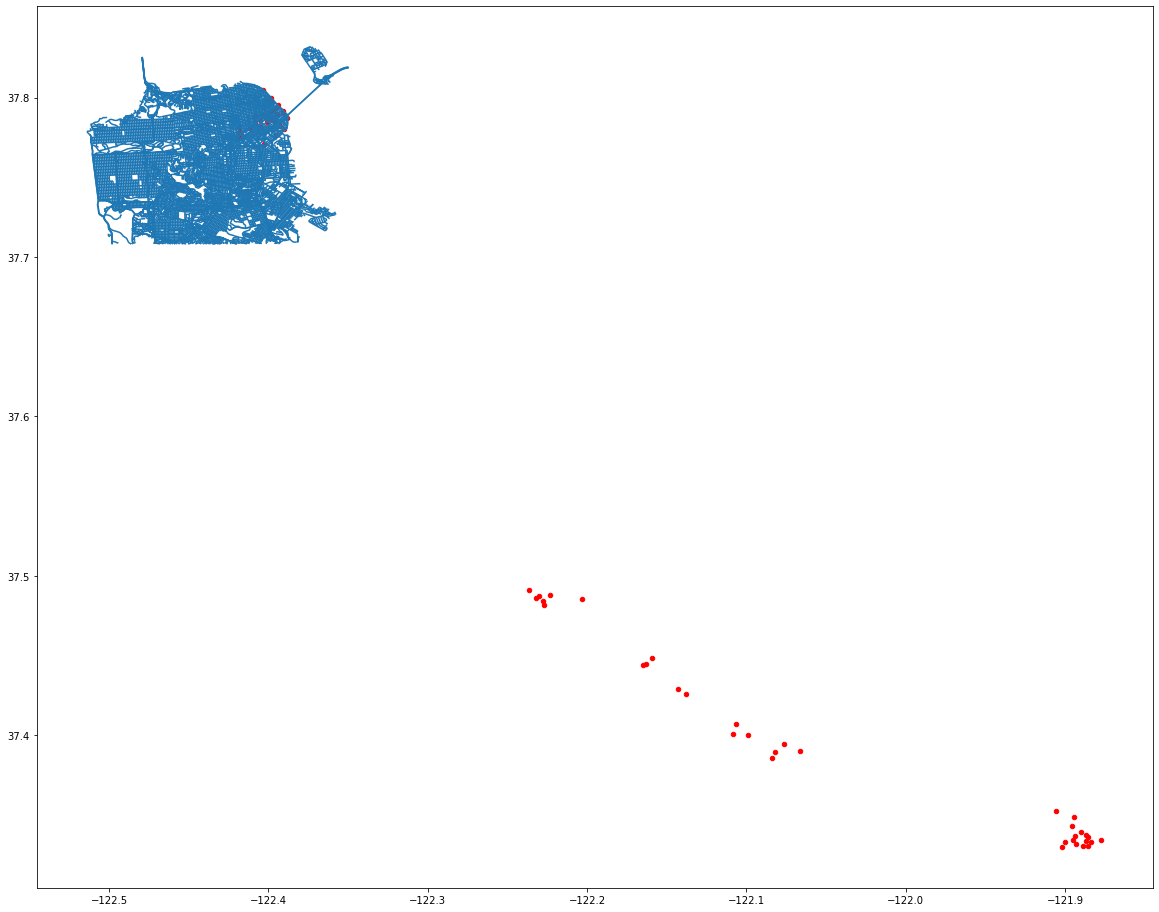

In [117]:
fig, ax = plt.subplots(figsize = (20,20))
shape_new.plot(ax=ax)shape_94100_94200
gpd.clip(geo_latlong)geo_latlong.plot(ax=ax, color="red", markersize=20)

In [78]:
shape_94100_94200 = shape[shape["ZIP_CODE_5"].between("94100", "94200")]
points_94100_94200 = gpd.clip(geo_df, shape_94100_94200)

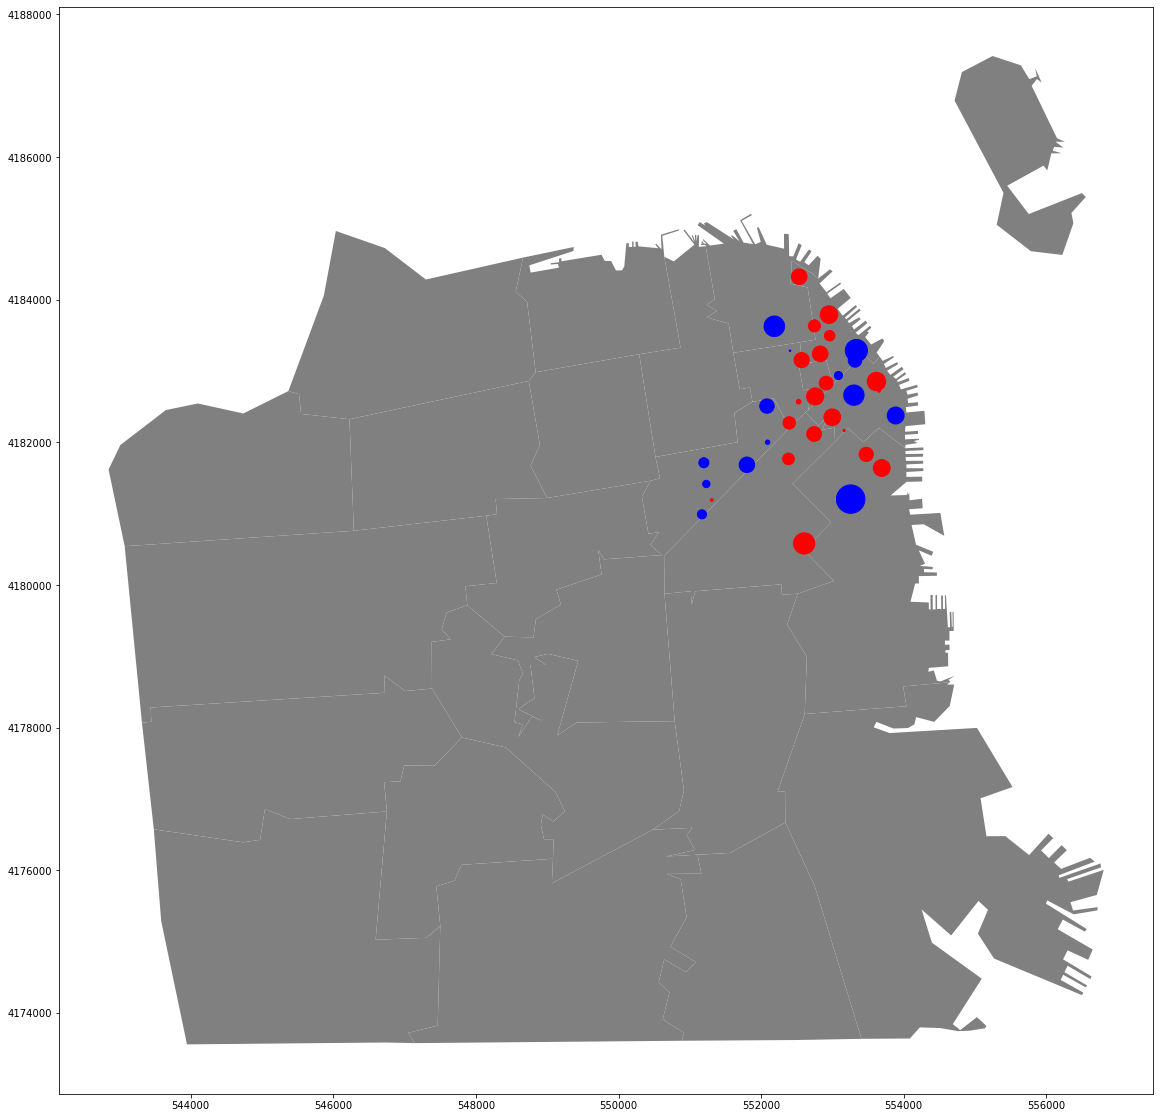

In [79]:
fig, ax = plt.subplots(figsize = (20,20))
shape_94100_94200.plot(ax=ax, color="grey")
points_94100_94200[points_94100_94200["diff"] > 0] \
.plot(ax=ax, color="blue", markersize=points_94100_94200[points_94100_94200["diff"] > 0]["diff"] *50)
points_94100_94200[points_94100_94200["diff"] < 0] \
.plot(ax=ax, color="red", markersize=np.abs(points_94100_94200[points_94100_94200["diff"] < 0]["diff"]) *50)

In [44]:
gpd.clip(geo_df, shape)

,station,ave_start_trips,ave_end_trips,id,name,lat,long,dock_count,city,installation_date,geometry
0,2nd at Folsom,4.669850,4.766712,62,2nd at Folsom,37.785299,-122.396236,19,San Francisco,8/22/2013,POINT (553163.285 4182165.561)
1,2nd at South Park,4.557981,8.630286,64,2nd at South Park,37.782259,-122.392738,15,San Francisco,8/22/2013,POINT (553473.488 4181830.269)
2,2nd at Townsend,9.346521,14.987722,61,2nd at Townsend,37.780526,-122.390288,27,San Francisco,8/22/2013,POINT (553690.483 4181639.397)
3,5th at Howard,3.897681,6.609823,57,5th at Howard,37.781752,-122.405127,15,San Francisco,8/21/2013,POINT (552382.902 4181767.005)
4,Adobe on Almaden,0.081855,0.684857,5,Adobe on Almaden,37.331415,-121.893200,19,San Jose,8/5/2013,POINT (598051.281 4132212.695)
5,Arena Green / SAP Center,0.081855,0.283765,14,Arena Green / SAP Center,37.332692,-121.900084,19,San Jose,8/5/2013,POINT (597439.759 4132347.249)
6,Beale at Market,6.911323,5.596180,56,Beale at Market,37.792251,-122.397086,19,San Francisco,8/20/2013,POINT (553083.466 4182936.400)
7,Broadway St at Battery St,2.335607,5.241473,82,Broadway St at Battery St,37.798541,-122.400862,15,San Francisco,1/22/2014,POINT (552746.533 4183632.136)
8,California Ave Caltrain Station,0.110505,0.298772,36,California Ave Caltrain Station,37.429082,-122.142805,15,Palo Alto,8/14/2013,POINT (575839.875 4142818.376)
9,Castro Street and El Camino Real,0.482947,1.195089,32,Castro Street and El Camino Real,37.385956,-122.083678,11,Mountain View,12/31/2013,POINT (581117.707 4138082.989)


More scooters could be allocated to these stations. 

## 2.5 The hot routes in afternoon rush hours

### 2.5.1 Start Stations

In [109]:
afternoon = sf_scooter[sf_scooter['Start Hour'].isin((16,17,18))]

In contrast, the starting stations in the afternoon are very evenly distributed. People may go off work from different work places at that time.

In [110]:
a_df_start_station = afternoon.groupby('Start Station').agg({'Start Terminal': np.mean, 'Trip ID': pd.Series.nunique}).sort_values(['Trip ID'], ascending=False)
a_df_start_station['Percentage'] = a_df_start_station['Trip ID']/sum(a_df_start_station['Trip ID'])
a_df_start_station

,Start Terminal,Trip ID,Percentage
Start Station,,,
Embarcadero at Sansome,60,2536,0.049088
2nd at Townsend,61,2428,0.046998
San Francisco Caltrain (Townsend at 4th),70,2384,0.046146
Market at Sansome,77,2282,0.044172
Townsend at 7th,65,2205,0.042681
...,...,...,...
Redwood City Medical Center,26,16,0.000310
Mezes Park,83,10,0.000194
San Mateo County Center,23,7,0.000135


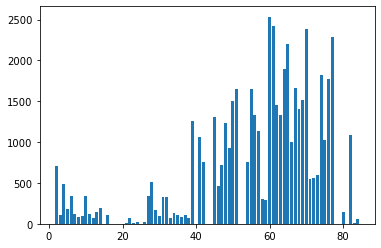

In [111]:
plt.bar(a_df_start_station['Start Terminal'], a_df_start_station['Trip ID'], align='center')#, alpha=0.5)
plt.show()

### 2.5.2 End Stations

We can see there is a significant gap between terminal 70 and other places again. To combine with the previous section, it could imply that the traffic flow which starts from 70 and heads to different places in the morning, now is comming back from different terminals in SF to terminal 70 again in the afternoon.  

In [112]:
a_df_end_station = afternoon.groupby('End Station').agg({'End Terminal': np.mean, 'Trip ID': pd.Series.nunique}).sort_values(['Trip ID'], ascending=False)
a_df_end_station['Percentage'] = a_df_end_station['Trip ID']/sum(a_df_end_station['Trip ID'])
a_df_end_station

,End Terminal,Trip ID,Percentage
End Station,,,
San Francisco Caltrain (Townsend at 4th),70,8560,0.165692
San Francisco Caltrain 2 (330 Townsend),69,3998,0.077388
Harry Bridges Plaza (Ferry Building),50,3154,0.061051
Steuart at Market,74,2361,0.045701
Temporary Transbay Terminal (Howard at Beale),55,2243,0.043417
...,...,...,...
Mezes Park,83,31,0.000600
Franklin at Maple,21,30,0.000581
Adobe on Almaden,5,18,0.000348


AS the graphs shows, the traffic flows go back to terminal 70

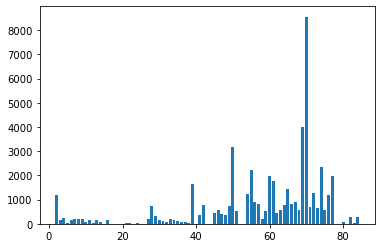

In [113]:
plt.bar(a_df_end_station['End Terminal'], a_df_end_station['Trip ID'], align='center')
plt.show()

## 2.6 The heatmap of demand and supply of the scooters in different stations.

such that people can know which place needs more scooters and which does not.

In [114]:
start_station = afternoon.groupby(['Start Station', 'Start Terminal']).agg(start_trips=('Trip ID', pd.Series.nunique)) \
.reset_index() \
.rename(columns={"Start Station": "Station", "Start Terminal": "Terminal"}) \

# calculate the average start trips
start_station = start_station.assign(ave_start_trips = start_station["start_trips"] / num_days)

end_station = afternoon.groupby(['End Station', 'End Terminal']).agg(end_trips=('Trip ID', pd.Series.nunique)) \
.reset_index() \
.rename(columns={"End Station": "Station", "End Terminal": "Terminal"})

# calcuate the average end trips
end_station = end_station.assign(ave_end_trips = end_station["end_trips"] / num_days)

In [115]:
start_end = start_station.merge(end_station, on=("Station", "Terminal"))[["Station", "ave_start_trips", "ave_end_trips"]].set_index("Station")

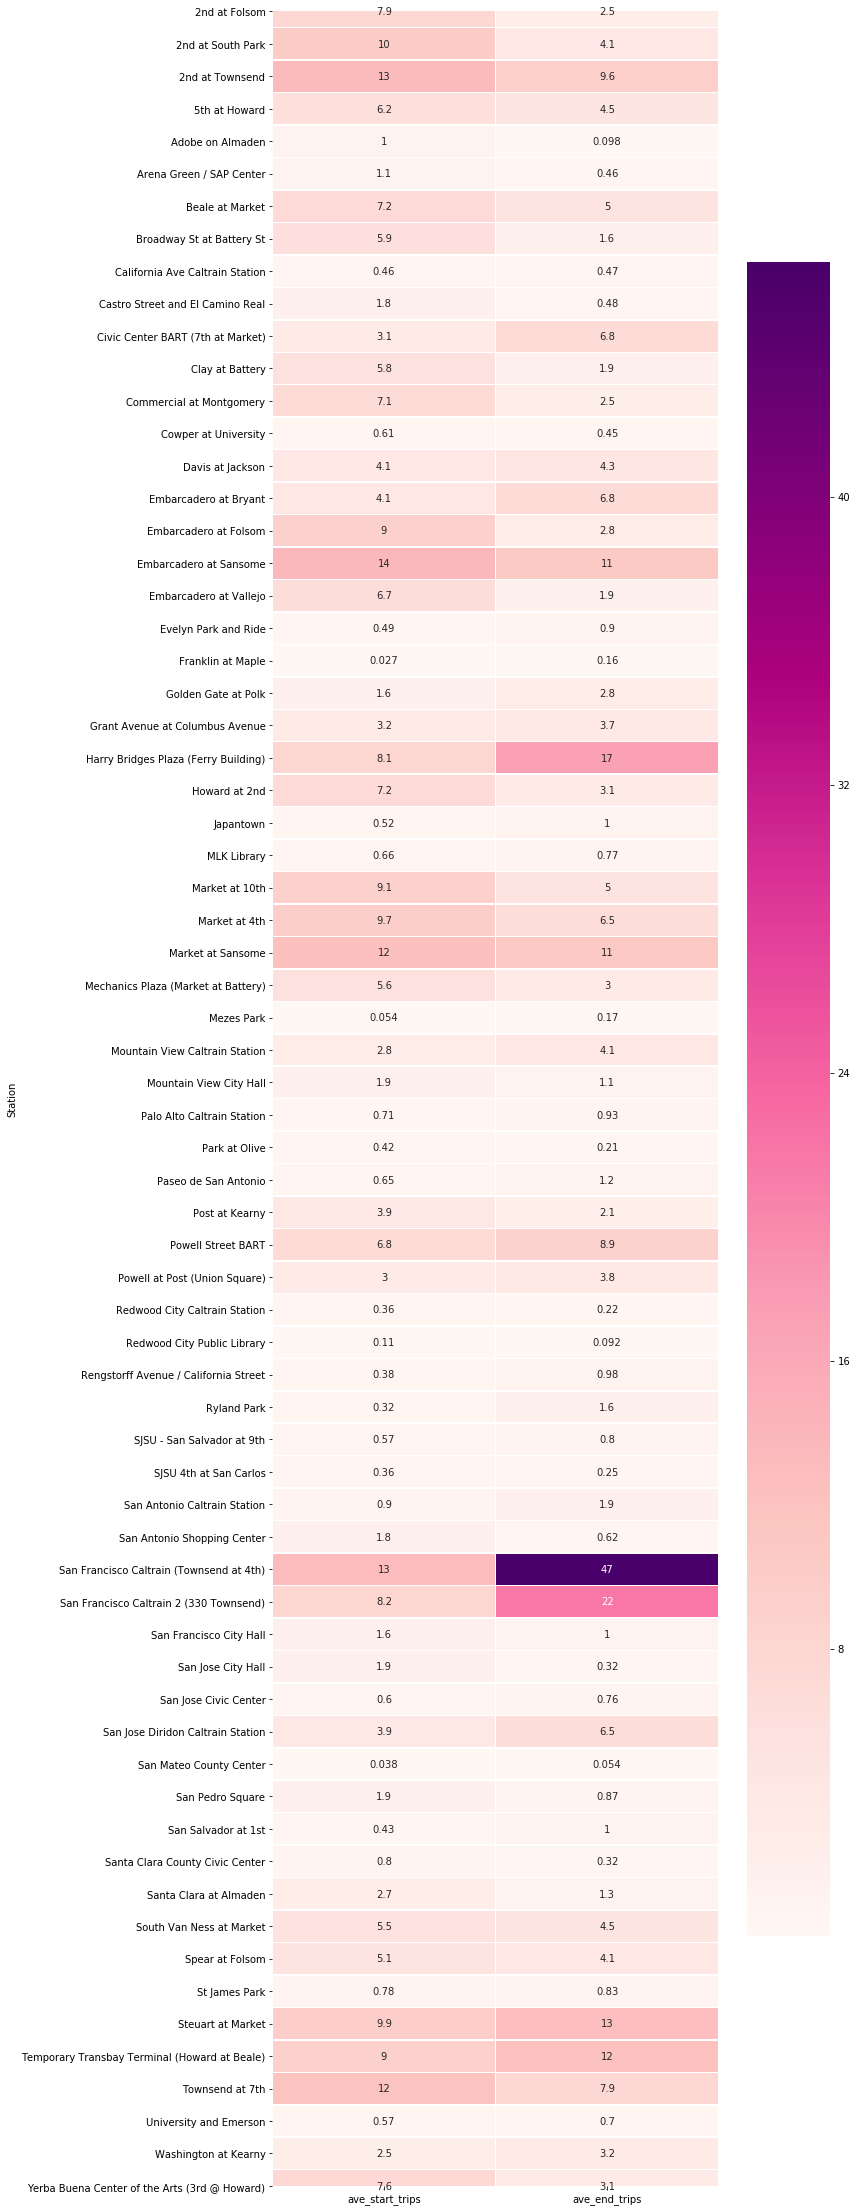

In [116]:
fig, ax = plt.subplots(figsize=(10,40))
sns.heatmap(start_end, ax=ax, annot=True, fmt=".2g", linewidths=.5, cmap="RdPu")

Filter the stations that need more scooters. Select by 

In [117]:
start_end[(start_end["ave_start_trips"] > start_end["ave_end_trips"] * 1.2) 
          & (start_end["ave_start_trips"] > start_end["ave_end_trips"] + 1)]

,ave_start_trips,ave_end_trips
Station,,
2nd at Folsom,7.913043,2.521739
2nd at South Park,10.282609,4.114130
2nd at Townsend,13.195652,9.614130
5th at Howard,6.184783,4.521739
Beale at Market,7.228261,5.000000
Broadway St at Battery St,5.896739,1.614130
Castro Street and El Camino Real,1.804348,0.478261
Clay at Battery,5.766304,1.940217
Commercial at Montgomery,7.108696,2.494565


More scooters could be allocated to these stations. 

In [118]:
#TODO: add in geo map

## 2.6 Conclusion 

According to the analysis above, there could be significantly large amount of passengers taking shared scooters travel from terminal 70 to other places in SF from 7 to 9 am, and then come back to terminal 70 in the afternoon from 4 to 6 pm. That could be very likely due to the commuting transportation that happens every day. Therefore, for potential further improvement, the escooter sharing company may consider to arrange more scooters near terminal 70 in the morning and other terminals which are the popular starting stations in the afternoon, to provide enough scooters for the passengers and optimize the customers' experience.  

# For the introduction of tableau visualizaiton 

I used the data provided in the email, integrating with the zipcode to GPS matching data and the polygon shapefile of San Francisco to plot the visualization. The developing work is done in tableau, and I have also attached the PDF screenshot of the dashboard in case you couldn't open it. The other two external data sources can be find below:

https://data.sfgov.org/Geographic-Locations-and-Boundaries/San-Francisco-ZIP-Codes/srq6-hmpi/data           
https://www.gaslampmedia.com/download-zip-code-latitude-longitude-city-state-county-csv/
